In [1]:
%pylab inline
import numpy as np
import pickle
import networkx as nx
from scipy import stats
from networkx import graphviz_layout

Populating the interactive namespace from numpy and matplotlib


In [2]:
FinalSummary = dict()

In [3]:
ls 'output_data/random_networks/'

summary_N10_samples100.txt                         summary_N_10_dH1.761596.txt
summary_N10_samples100_wilson.pkl                  summary_N_10_dH1.761596timeseries.png
summary_N10_samples100_wilson.txt                  summary_N_10_dH2.594713.png
summary_N20_samples100_spine_9spurs.pkl            summary_N_10_dH2.594713.txt
summary_N20_samples100_spine_9spurs.txt            summary_N_10_dH2.594713timeseries.png
summary_N20_samples100_spine_random_BC.pkl         summary_N_10_dH3.269438.png
summary_N20_samples100_spine_random_BC.txt         summary_N_10_dH3.269438.txt
summary_N20_samples100_spine_random_Mr.pkl         summary_N_10_dH3.269438timeseries.png
summary_N20_samples100_spine_random_Mr.txt         summary_N_10_dH3.404951.png
summary_N20_samples100_spine_random_h0.pkl         summary_N_10_dH3.404951.txt
summary_N20_samples100_spine_random_length.pkl     summary_N_10_dH3.404951timeseries.png
summary_N20_samples100_spine_random_length.txt     summary_N_10_dH3.915981.png
summary_N20_

In [4]:
def ave_slope(elevs,conns,L):
    Np = shape(conns)[0]
    s = [(elevs[conns[k,1]]-elevs[conns[k,0]])/L for k in range(Np)]
    return mean(s)

In [140]:
def namestuff(which_p):
    if which_p =='h0':
        name = loc+'summary_N20_samples100_spine_random_h0.pkl'
        xlims = [0,0.1]
        xlab = r'$h_0 (m)$'
    elif which_p=='elevs':
        name = loc+'summary_N20_samples34_spine_random_elevs.pkl'
        xlims = [-.06,.06]
        xlab= r'$\langle S_0 \rangle$'
    elif which_p =='Q0':
        name = loc+'summary_N20_samples100_spine_random_BC.pkl'
        xlims = [90,190]
        xlab = r'$Q_0$ (gal/min)'
    elif which_p =='Mr':
        name = loc+'summary_N20_samples100_spine_random_Mr.pkl'
        xlims =[0.002,.016]
        xlab = r'$M_r$'
    elif which_p =='a':
        name = loc+'summary_N20_samples100_spine_random_wavespeed.pkl'
        xlims =[80,240]
        xlab = 'a'
    elif which_p =='conn1deg3':
        name =loc+'summary_N20_samples100_wilson.pkl'
        xlims = [0,9]
        xlab= '# nodes degree 3'
    elif which_p =='conn2deg3':
        name =loc+'Summary_N20_samples100_spine_variable_spurs.pkl'
        xlims = [0,9]
        xlab= '# nodes degree 3'
    elif which_p =='conn1diam':
        name =loc+'summary_N20_samples100_wilson.pkl'
        xlims = [6,20]
        xlab = 'network diameter'
    elif which_p =='conn2diam':
        name =loc+'Summary_N20_samples100_spine_variable_spurs.pkl'
        xlims = [9,20]
        xlab = 'network diameter'
    return(name, xlims, xlab)

In [164]:
#N = 14
m32gal = 264.172
s2min = 60.
loc = 'output_data/random_networks/'

names = ['h0','Q0','a','Mr','conn1diam','conn2deg3']
defaults = [1,0,0.0087,100.,0.007,14,5]     #values of x for parameters not being varied

Nparam = len(defaults)-1
Nvary = len(names)
Ntr = 100 # I just know this (should load trial data and then decide...)
N = 14
z =  np.kron(defaults,np.ones((Ntr*Nvary,1)))#parameter sample matrix
y0 = np.zeros(Nvary*Ntr)   #time to pressurization
y1 = np.zeros(Nvary*Ntr)   #mean (dH)
y2 = np.zeros(Nvary*Ntr)   #stddev(arrival times in each pipe)
y3 = np.zeros(Nvary*Ntr)   #mean(max H in each pipe)


In [165]:
for W in range(0,Nvary):
    which_p = names[W]
    print which_p
    (name, xlims, xlab )= namestuff(which_p)
    f = open(name,'rb')
    Summary = pickle.load(f)
    f.close()
    #Ntr = len(Summary)

#x will be the vector of parameters
    ztemp = defaults
    print Summary[0].keys()
    Np = len(Summary[0]['max_H'])
    x = np.zeros(Ntr)

    if which_p[0:3] =='con':
        Np =N+10
    
    Ntr = len(Summary)
    late = np.zeros(Ntr)
    diams = np.zeros(Ntr)
    maxHs = np.zeros((Ntr,Np))
    meandH = np.zeros(Ntr)
    arrive_t = np.zeros((Ntr,Np))
    deg = np.zeros((Ntr,3))
    farthest = np.zeros(Ntr,int)

    
    
    for k in range(Ntr):
        late[k] = Summary[k]['last_arrive_t']
        Np = len(Summary[k]['max_H'])
        maxHs[k,0:Np] =Summary[k]['max_H'][0:Np]
        meandH[k] = Summary[k]['mean_dH']
        arrive_t[k,0:Np]=Summary[k]['min_arrive_t'][0:Np]
        if which_p =='h0':
            x[k] = Summary[k]['h0']
        elif which_p =='elevs':
            x[k] = ave_slope(Summary[k]['elevs'],Summary[k]['conn'],20.)
        elif which_p =='Q0':
            x[k] = Summary[k]['Q00']    
        elif which_p =='Mr':
            x[k] = Summary[k]['Mrs'][0]
        elif which_p=='a':
            x[k] =Summary[k]['a']
        elif which_p[0:3] =='con':
            c = [Summary[k]['nodeTypes'].count(j) for j in range(1,4)]
            deg[k,:] = (c[0], c[1],c[2])
            conns = Summary[k]['conn']
            Np = shape(conns)[0]
            G=nx.Graph()
            for j in range(Np):
                G.add_edge('%d'%conns[j,0],'%d'%conns[j,1])
            Dorig = nx.single_source_shortest_path_length(G,'0')
            x = Dorig.values()
            ftemp= Dorig.keys()[x.index(max(x))]
            zt = find(conns==int(ftemp))
            farthest[k] =zt[0]/2
            diams[k] =nx.diameter(G)


    if which_p[-1]  =='m':
        x = diams
    elif which_p[-1] =='3':
        x = deg[:,2]
    sa = std(arrive_t,1)
    mmH = mean(maxHs,1)
    mmH = maxHs.max(1)
    print len(x)
    print W*Ntr
    print (W+1)*Ntr
    print shape(z)
    z[W*Ntr:(W+1)*Ntr, W+1] = x
    y0[W*Ntr:(W+1)*Ntr] = late
    y1[W*Ntr:(W+1)*Ntr] = meandH
    y2[W*Ntr:(W+1)*Ntr] = sa
    y3[W*Ntr:(W+1)*Ntr] = mmH

h0
['mean_dH', 'h0', 'Vin', 'max_H', 'last_arrive_t', 'nodeTypes', 'max_arrive_t', 'conn', 'min_arrive_t']
100
0
100
(600, 7)
Q0
['elevs', 'mean_dH', 'Vin', 'max_H', 'last_arrive_t', 'conn', 'Q00', 'max_arrive_t', 'nodeTypes', 'min_arrive_t']
100
100
200
(600, 7)
a
['a', 'mean_dH', 'Vin', 'max_H', 'last_arrive_t', 'nodeTypes', 'max_arrive_t', 'conn', 'min_arrive_t']
100
200
300
(600, 7)
Mr
['mean_dH', 'Vin', 'max_H', 'Mrs', 'last_arrive_t', 'nodeTypes', 'max_arrive_t', 'conn', 'min_arrive_t']
100
300
400
(600, 7)
conn1diam
['mean_dH', 'Vin', 'max_H', 'last_arrive_t', 'nodeTypes', 'max_arrive_t', 'conn', 'min_arrive_t']
100
400
500
(600, 7)
conn2deg3
['mean_dH', 'Vin', 'max_H', 'last_arrive_t', 'nodeTypes', 'max_arrive_t', 'conn', 'min_arrive_t']
100
500
600
(600, 7)


In [166]:
ys = [y0,y1,y2,y3]

bh2 = np.zeros((4,Nparam))
r = np.zeros(4)
print "                 R      h0        Q0        a         Mr        diam     #deg3"
s = ['max(T_a)     ', 'mean(dH)     ', 'std(T_a)     ','mean(max(H)) ']
for i in range(4):
    y = ys[i]
    sol = np.linalg.lstsq(z,y)
    sigmay = np.std(y)
    b = sol[0]#least squares coeffs for y = b0+\sum_i b_i z_i for parameters z
    bz= b[1:] #coeffs corresponding to params

    for K in range(Nparam):
        sigmaz = np.std(z[:,K+1])
        bh2[i,K]=(bz[K]*sigmaz/sigmay)**2
    r[i] = sum(bh for bh in bh2[i,:])
    print "%s %f  %f  %f  %f  %f  %f %f"%tuple([s[i],r[i]]+[bh for bh in bh2[i,:]])


                 R      h0        Q0        a         Mr        diam     #deg3
max(T_a)      0.941960  0.647443  0.062840  0.000479  0.004491  0.008936 0.217771
mean(dH)      0.378973  0.004279  0.000002  0.013379  0.008403  0.000045 0.352865
std(T_a)      0.844438  0.581925  0.060662  0.003766  0.001590  0.026699 0.169796
mean(max(H))  0.882643  0.842149  0.000293  0.030248  0.003190  0.000004 0.006758


In [ ]:

                 R      h0        Q0        a         Mr        diam     #deg3
max(T_a)      0.846388  0.750102  0.075692  0.000026  0.008642  0.006974 0.004951
mean(dH)      0.111342  0.003929  0.000000  0.056920  0.039428  0.003523 0.007543
std(T_a)      0.762890  0.664876  0.065295  0.008095  0.000206  0.019528 0.004892
mean(max(H))  0.876646  0.840606  0.000298  0.031575  0.003728  0.000011 0.000428

Q0


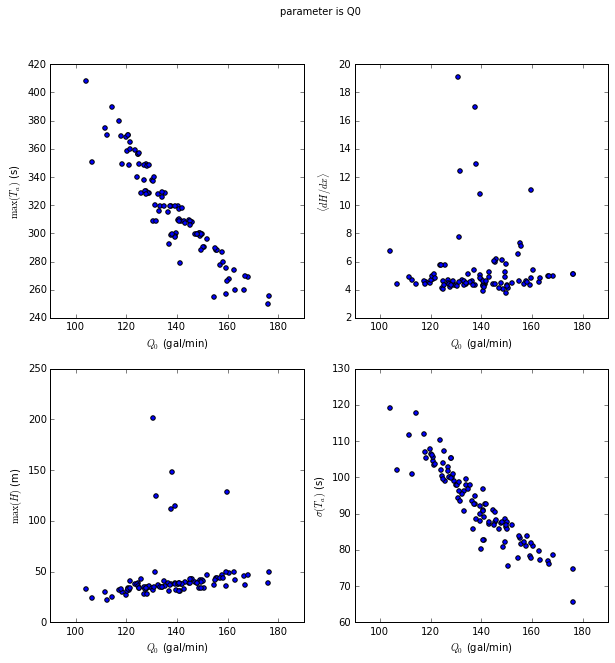

In [158]:
W = 1
which_p = names[W]
x = z[W*Ntr:(W+1)*Ntr, W+1]
if W==1:
    x = x*m32gal*s2min
late = y0[W*Ntr:(W+1)*Ntr]
meandH =  y1[W*Ntr:(W+1)*Ntr]
mmH = y3[W*Ntr:(W+1)*Ntr]
sa =  y2[W*Ntr:(W+1)*Ntr]

print which_p
(name, xlims, xlab )= namestuff(which_p)
fig, ax = plt.subplots(figsize = (10,10), ncols =2, nrows = 2)
fig.suptitle('parameter is '+which_p)
ax[0,0].scatter(x,late)
ax[0,0].set_ylabel(r'$\max(T_a)$ (s)')
ax[0,1].scatter(x,meandH)
ax[0,1].set_ylabel(r'$\langle dH/dx\rangle$')
ax[1,0].scatter(x,mmH)
ax[1,0].set_ylabel(r'$\max (H)$ (m)')
ax[1,1].scatter(x,sa)
ax[1,1].set_ylabel(r'$\sigma(T_a)$ (s)')
for i in range(2):
    for k in range(2):
        ax[i,k].set_xlim(xlims) 
        ax[i,k].set_xlabel(xlab)



In [44]:
Summary[0].keys()

['mean_dH',
 'Vin',
 'max_H',
 'last_arrive_t',
 'nodeTypes',
 'max_arrive_t',
 'conn',
 'min_arrive_t']

In [77]:
print FinalSummary

{'conn1diam': array([-0.09924485,  0.09466247,  0.19319863, -0.24203086]), 'conn2deg3': array([ 0.97485695, -0.66607605,  0.56694451,  0.92378564]), 'conn1deg3': array([ 0.24377254, -0.13344113, -0.0944433 ,  0.3194522 ]), 'conn2diam': array([ 0.,  0.,  0.,  0.])}


late arrivals
[ 0 28 49 62 73 94]
early arrivals
[ 1  8 19 41 70 76 85 86]
arrival time range is [190.648000, 399.632000]
small dH/dx
[17 32 97]
large dH/dx
[ 1  8 19 41 48 70 76 85 86]
dH/dx range is [3.357562, 58.896550]


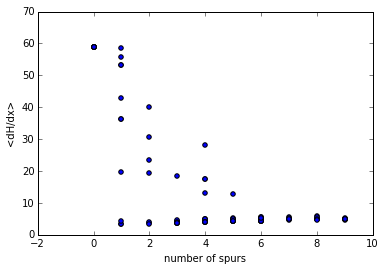

In [22]:
#hist(meandH, bins = 50)
#print find(meandH ==max(meandH))
print "late arrivals" 
print find(late >max(late)*.95)
print "early arrivals"
print find(late < min(late)*1.05)
print "arrival time range is [%f, %f]"%(min(late), max(late))
print "small dH/dx"
print find(meandH <min(meandH)*1.05)
print "large dH/dx"
print find(meandH>max(meandH)*.95)
print "dH/dx range is [%f, %f]"%(min(meandH),max(meandH))

Hs1 = maxHs.min(axis=1)
Hs2 = maxHs.max(axis=1)
#hist(Hs1, bins = 50)
#hist(Hs2, bins = 50)
#scatter(mean(maxHs,1),mean(arrive_t,1))
#scatter([arrive_t[k,farthest[k]] for k in range(Ntr)],deg[:,2])
#scatter(deg[:,2],[maxHs[k,farthest[k]] for k in range(Ntr)])

#scatter(deg[:,2],[arrive_t[k,farthest[k]] for k in range(Ntr)])

#for spine data
#scatter(deg[:,2],late)
#scatter(mean(maxHs,1),late)
#scatter(deg[:,2],mean(maxHs,1))
scatter(deg[:,2],meandH)
xlabel('number of spurs')
ylabel('<dH/dx>')


In [17]:
print shape(z)
print shape(y1)

(6, 600)
(600,)


In [120]:
print np.std(y3)
print np.std()

88.5327917421


In [388]:
conns = Summary[0]['conn']
Np = shape(conns)[0]
G=nx.Graph()
for j in range(Np):
    G.add_edge('%d'%conns[j,0],'%d'%conns[j,1])
Dorig = nx.single_source_shortest_path_length(G,'0')
x = Dorig.values()
ftemp= Dorig.keys()[x.index(max(x))]

1
{'11': 6, '10': 4, '13': 3, '12': 2, '15': 4, '14': 6, '17': 4, '16': 5, '19': 6, '18': 3, '1': 8, '0': 0, '3': 7, '2': 8, '5': 7, '4': 5, '7': 8, '6': 5, '9': 4, '8': 1}
[[ 5  1]
 [ 3  2]
 [11  3]
 [15  4]
 [11  5]
 [15  6]
 [ 3  7]
 [ 0  8]
 [13  9]
 [13 10]
 [16 11]
 [ 8 12]
 [12 13]
 [ 6 14]
 [18 15]
 [10 16]
 [18 17]
 [12 18]
 [ 6 19]]


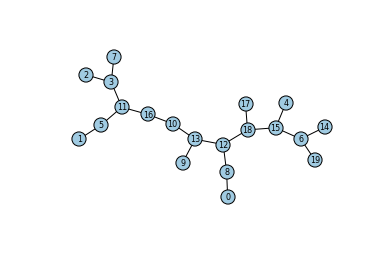

In [393]:
print ftemp
print Dorig
pos = nx.graphviz_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=200,node_color = '#A0CBE2')
# edges
nx.draw_networkx_edges(G,pos,width=1,edge_cmap=plt.cm.ocean)
#nx.draw_networkx_edges(G,pos,width=3,alpha=0.2)
# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
print conns

In [376]:
shape(arrive_t[:,transpose(farthest)])

(100, 100)

In [21]:
print find(late==0)

[]


In [98]:
r = np.zeros(4)
b00,b10,r[0],p0,err0 = stats.linregress(x,late)
b01,b11,r[1],p1,err1 = stats.linregress(x,meandH)
b02,b12,r[2],p2,err2 = stats.linregress(x,mmH)
b03,b13,r[3],p3,err3 = stats.linregress(x,sa)
print r
FinalSummary[which_p] = r

[ 0.24377254 -0.13344113 -0.0944433   0.3194522 ]


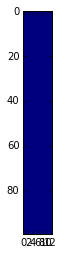

In [460]:
imshow(arrive_t>0)

['11', '10', '13', '12', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8']
58.8965497546


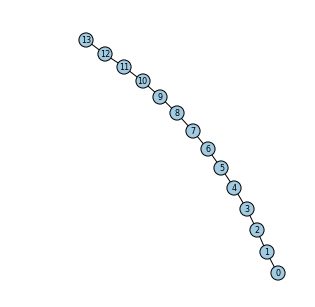

In [25]:
G2 = nx.Graph()
fig, ax = plt.subplots(figsize = (5,5))
Np = N-1
for k in range(Np):
    G2.add_edge('%d'%conns[k,0],'%d'%conns[k,1])
print G2.nodes()
pos2 ={k:pos[k] for k in G2.nodes()}
values = [(scale*xx,scale*yy) for xx,yy in pos2.values()]
posbig = {'%d'%k:values[k] for k in range(N)}
# nodes
nx.draw_networkx_nodes(G2,pos2,node_size=200,node_color = '#A0CBE2')
# edges
nx.draw_networkx_edges(G2,pos2,width=1,edge_cmap=plt.cm.ocean)
#nx.draw_networkx_edges(G,pos,width=3,alpha=0.2)
# labels
nx.draw_networkx_labels(G2,pos2,font_size=8,font_family='sans-serif')
plt.axis('off')
xmax=1.14*max(xx for xx,yy in pos2.values())
ymax=1.14*max(yy for xx,yy in pos2.values())
xmin=min(xx for xx,yy in pos2.values())
ymin=min(yy for xx,yy in pos2.values())
plt.xlim(-sign(xmin)*1.1*xmin,xmax)
plt.ylim(-sign(ymin)*1.1*ymin,ymax)
#savefig('/Users/lieba/Desktop/spineN14.eps')
print Summary[which]['mean_dH']

In [479]:
for k in range(14):
    print len(find(arrive_t[:,k]==0))

0
0
0
0
0
0
0
0
0
0
0
0
0
22


7
14
5


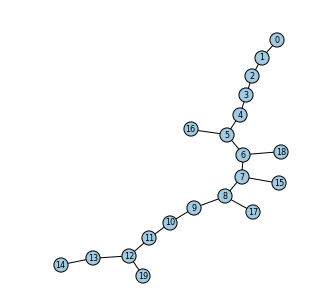

In [33]:
#cool graphs! 87,1,40,73,17...? 
#for spine data:  min dH is 17, small ones are also...5,97
#                 maxdH is [ 1  8 19 41 70 76 85 86] (these have no spurs) and also 48
#                max late is 42
#                min late is [ 1  8 19 41 70 76 85 86]
which = 1
conns = Summary[which]['conn']
Np = shape(conns)[0]
scale = 20
G=nx.Graph()
for k in range(Np):
    G.add_edge('%d'%conns[k,0],'%d'%conns[k,1])

pos=nx.graphviz_layout(G,root=0)
fig, ax = plt.subplots(figsize = (5,5))
values = [(scale*xx,scale*yy) for xx,yy in pos.values()]
posbig = {'%d'%k:values[k] for k in range(Np)}
# nodes
nx.draw_networkx_nodes(G,pos,node_size=200,node_color = '#A0CBE2')
# edges
nx.draw_networkx_edges(G,pos,width=1,edge_cmap=plt.cm.ocean)
#nx.draw_networkx_edges(G,pos,width=3,alpha=0.2)
# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
xmax=1.14*max(xx for xx,yy in pos.values())
ymax=1.14*max(yy for xx,yy in pos.values())
xmin=min(xx for xx,yy in pos.values())
ymin=min(yy for xx,yy in pos.values())
plt.xlim(-sign(xmin)*1.1*xmin,xmax)
plt.ylim(-sign(ymin)*1.1*ymin,ymax)
print nx.radius(G)
print nx.diameter(G)
print Summary[0]['nodeTypes'].count(3)

In [43]:
print defaults

[0, 0.0087, 100.0, 0.007, 14, 5]


In [228]:
print len(Summary[2]['max_H'])
print len(Summary[0]['max_arrive_t'])

20
23


In [60]:
shape(np.kron(defaults,np.ones((10,1))))

(10, 6)

In [65]:
z =  np.transpose(np.kron(defaults,np.ones((Ntr*Nvary,1))))

[0.72701925133619938, 0.0020470414755661514, 5.7410757018944981e-05, 0.011172638575508945, 0.0048722546745884852, 0.0045076506398830755]
0.749676247459
0.438431547932


In [88]:
find(y3<10)

array([246, 289, 401, 402, 404, 409, 435, 439, 444, 445, 451, 454, 467,
       473, 477, 490, 491, 532, 538, 545, 547, 548, 558, 563, 590, 592])